<a href="https://colab.research.google.com/github/ravr19/shared/blob/master/ML4EGS_Autoencoder_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder vs. PCA

You may have been told several times that autoencoder with single layer (for both encoder and decoder) approximates PCA. This tutorial will compare autoencoder and PCA by using MNIST dataset.

## PCA
First, we try PCA to reconstruct MNIST data ($28\times 28$) with a reduced dimension of $32$.

In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Using TensorFlow backend.


In [0]:
w,V = np.linalg.eig(x_train.T.dot(x_train))

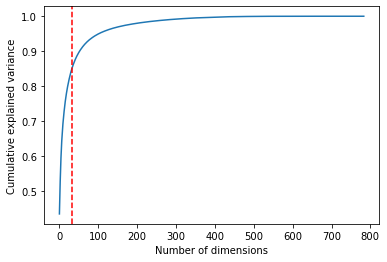

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(w)/np.sum(w))
plt.axvline(x=32, ymin=0, ymax=1, color='r', ls='--')
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance')
plt.show()

It looks like PCA reconstruction should achieve ~85% explained variance with 32 dimensions.

Let's take a look at several reconstructed samples.

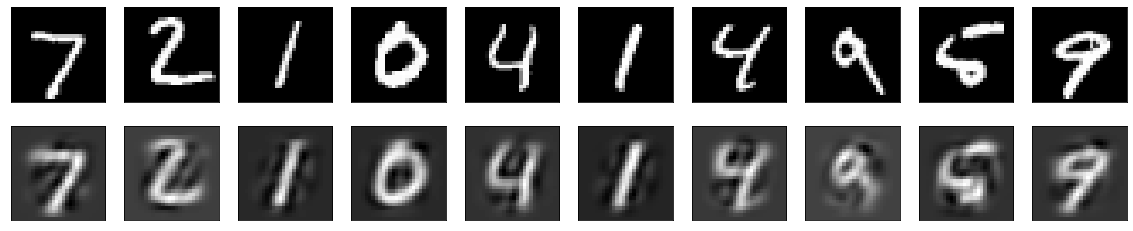

In [0]:
n = 10  # how many digits we will display
dim_PCA = 32 # how many dimensions we use for PCA reconstruction
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display PCA reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    V_PCA = V[:,:dim_PCA]
    x_test_PCA = V_PCA.dot(x_test[i].dot(V_PCA))
    plt.imshow(x_test_PCA.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Autoencoder with single linear layer
Now it's time to compare PCA and autoencoder. We first train a simple autoencoder without nonlinearity, in order to illustrate that autoencoder approximates PCA with this simple setting.

In [0]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='linear')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.3302 - val_loss: 0.2357
Epoch 2/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.2106 - val_loss: 0.1895
Epoch 3/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1819 - val_loss: 0.1710
Epoch 4/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.1674 - val_loss: 0.1586
Epoch 5/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.1561 - val_loss: 0.1481
Epoch 6/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.1472 - val_loss: 0.1417
Epoch 7/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.1417 - val_loss: 0.1367
Epoch 8/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.1373 - val_loss: 0.1328
Epoch 9/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.1336 - val_loss: 0.1305
Epoch

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

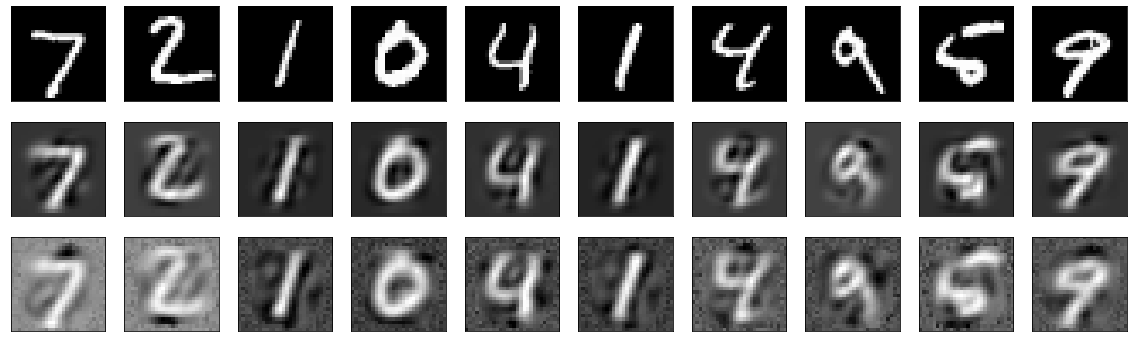

In [0]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display PCA reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    V_PCA = V[:,:dim_PCA]
    x_test_PCA = V_PCA.dot(x_test[i].dot(V_PCA))
    plt.imshow(x_test_PCA.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display linear autoencoder reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**First row**: true MNIST data

**Second row**: PCA

**Third row**: autoencoder without nonlinearity

It turns out that the results from autoencoder without nonlinearity look quite similar to the ones from PCA. Let's see if the coefficient matrix of autoencoder approximates the transformation matrix of PCA in some sense. Here we diagnosis the orthogonality between the bases of the linear transformation matrix (the coeffiient matrix of encoder).

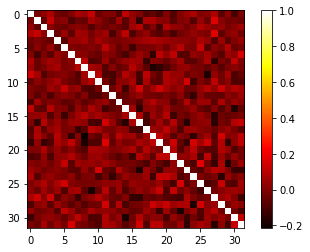

In [0]:
V_encoder = encoder.get_weights()[0]
V_encoder_is_unitary = V_encoder.T.dot(V_encoder)
plt.imshow(V_encoder_is_unitary/np.diag(V_encoder_is_unitary),cmap='hot')
plt.colorbar()
plt.show()

However, it's not very interesting to burn more computational resources to get similar performance of PCA. Let's see if adding nonlinearity into autoencoder improves the performance of dimension reduction.

In [0]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.3584 - val_loss: 0.2709
Epoch 2/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.2633 - val_loss: 0.2520
Epoch 3/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.2424 - val_loss: 0.2305
Epoch 4/50
60000/60000 [==============================] - 4s 58us/step - loss: 0.2234 - val_loss: 0.2140
Epoch 5/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.2095 - val_loss: 0.2023
Epoch 6/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.1989 - val_loss: 0.1927
Epoch 7/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1901 - val_loss: 0.1848
Epoch 8/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1830 - val_loss: 0.1784
Epoch 9/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.1769 - val_loss: 0.1727
Epoch

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_nonlinear_imgs = encoder.predict(x_test)
decoded_nonlinear_imgs = decoder.predict(encoded_nonlinear_imgs)

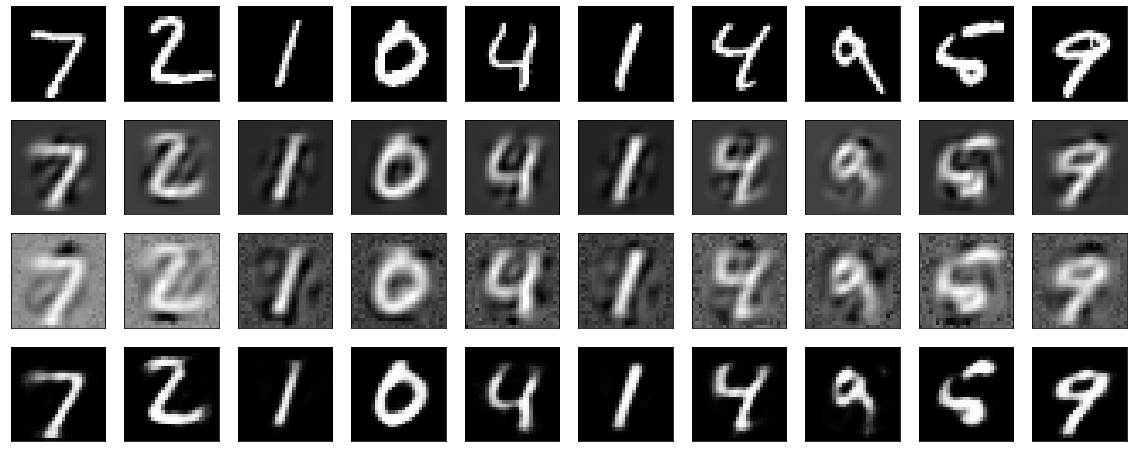

In [0]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display PCA reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    V_PCA = V[:,:dim_PCA]
    x_test_PCA = V_PCA.dot(x_test[i].dot(V_PCA))
    plt.imshow(x_test_PCA.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display linear autoencoder reconstruction
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display nonlinear autoencoder reconstruction
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(decoded_nonlinear_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**First row**: true MNIST data

**Second row**: PCA

**Third row**: autoencoder without nonlinearity

**Fourth row**: autoencoder with nonlinearity

It looks like that the lower dimensional latent space ($\mathbb{R}^{32}$) of autoencoder successfully encodes most information of the original space ($\mathbb{R}^{784}$). By adding nonlinearity, the performance of autoencoder is noticeably better than PCA.

I hope that you have been (partly) convinced that autoencoder is a more powerful tool for dimension reduction compared to PCA. Some materials of autoencoder in this tutorial are adopted from a tutorial at the Keras blog: https://blog.keras.io/building-autoencoders-in-keras.html. This link is also a good start point if you would like to see more flavors of autoencoder for the same dataset (MNIST) before playing with your own datasets.